# Problema 3

Se tiene un partícula de masa $m=1$ en un campo gravitacional $\vec{g}=-9.8\hat{j}$ en una caja como se muestra en la figura con $L=10m\ $ y $\ d=3m$.Realice los ejercicios con $\alpha=\frac{\pi}{6},\frac{\pi}{10}$. 
<img src="Figura_p3.png" style="width: 30%; height: 30%"/>. 

**a)** Realice una simulación con condición inicial talque que la posición inicial está sobre la rampa a un tercio de la distancia de la pared vertical izquierda y el vértice inferior de la caja, y se dispara con velocidad $|\vec{v}|=1$ y se dispara hacia la derecha con ángulos sobre la horizontal $\alpha,2\alpha\ $ y $\ 3\alpha$. Para que la simulación sea válida la partícula debe rebotar almenos 20 veces con alguna parte de la caja.

**b)**Introduzca algún modelo de fricción y compare las trayectorias con el inciso anterior.

**c)**Realice los ejercicios en los incisos a) y b) pero ahora con $|\vec{v}|=25\ $ y $\ |\vec{v}|=60$. Describa las similitudes y diferencias entre ambas simulaciones.

**d)**Dibuje el espacio fase $(x,p_x)\ $ y $\ (y,p_y)$ cuando no hay fricción y la partícula es lanzada hacia la derecha y verticalemente hacia arriba formando un ángulo $\alpha$ con la horizontal.  Tome en cuenta el número necesario de rebotes para que la simulación pueda barrer el espacio fase de manera representativa.

# Solución

Para integrar utilizaremos el método de Runge-Kutta de 4o orden que hemos utilizado anteriormente.

In [110]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def arg_rk4(funcion,x0,tlist,args=0,h=0.1):
    """
    Funcion de Integracion por el Metodo de Runge-Kutta a 4o orden. Sus argumentos son: la funcion de la ecuacion diferencial,
    el valor de la funcion al tiempo inicial x0,una lista con el tiempo inicial y el final tlist=[ti,tf] y 
    el paso de integracion como argumento opcional. 
    Puede tener una lista de parametros opcionales args que se pasan a la funcion de la ecuacion diferencial.
    Regresa los tiempos y sus respectivos valores de la funcion como una tupla de arrays t,x. 
    Cabe notar que la funcion, el jacobiano y x0 pueden tomar valores vectoriales, los cuales se representan por arrays.
    Tambien, la funcion debe tener ordenados los parámetros de la forma g(t,x).
    """
    if (tlist[1]-tlist[0])<10.0*h:   #cambia el valor de h para garantizar que se hagan almenos 10 iteraciones
        h=(tlist[1]-tlist[0])*0.1
    tiempos=np.arange(tlist[0],tlist[1],h) #regresa un array
    x = np.zeros((len(tiempos),len(x0)))#regresa otro array del ancho de la dimension de x0 y el largo del array de tiempos)
    x[0,:] = x0 #x[tiempo,coordenada],:==todas las coordenadas
    if args == 0:  #no hay argumentos opcionales dados    
        for i in xrange(0,len(tiempos)-1):
            k1=funcion(tiempos[i],x[i,:])
            k2=funcion(tiempos[i]+0.5*h,x[i,:]+0.5*h*k1)
            k3=funcion(tiempos[i]+0.5*h,x[i,:]+0.5*h*k2)
            k4=funcion(tiempos[i]+h,x[i,:]+h*k3)
            x[i+1,:]=x[i,:]+(1/6.0)*h*(k1+2*k2+2*k3+k4)    
    else:
        for i in xrange(0,len(tiempos)-1):
            k1=funcion(tiempos[i],x[i,:],args)
            k2=funcion(tiempos[i]+0.5*h,x[i,:]+0.5*h*k1,args)
            k3=funcion(tiempos[i]+0.5*h,x[i,:]+0.5*h*k2,args)
            k4=funcion(tiempos[i]+h,x[i,:]+h*k3,args)
            x[i+1,:]=x[i,:]+(1/6.0)*h*(k1+2*k2+2*k3+k4)    
    return tiempos,x 
#regresa una tupla, que la hace inmutable a diferencia de una lista y que, a diferencia de un array, 
#cada entrada puede ser de distinto tipo (heterogéneas)

Ahora defininimos la ecuación de movimiento que utilizaremos en el problema. Sabemos que, si $\vec{x}(t)$ es la posición del cuerpo, entonces la ecuación diferencial a resolver es: 
$m\ \ddot{\vec{x}} =\vec{f}_{fric}(\dot{\vec{x}})-\vec{g}$, donde $\vec{f}_{fric}$ es una fuerza de fricción dependiente sólo de la velocidad del cuerpo. Con esto, el sistema de ecuaciones se puede escribir como:
$\dot{\vec{X}}=\vec{G}(t,\vec{X})$, con $\vec{X}=(\vec{x_1},\vec{x_2})=(x,y,v_x,v_y)$ y $\vec{G}=(\vec{x_2},\frac{\vec{f}(\dot{\vec{x}})}{m}-\frac{\vec{g}}{m} )=(vx,vy,\frac{f_x(\dot{\vec{x}})}   {m},\frac{f_y(\dot{\vec{x}})}{m}-\frac{g}{m})$.

In [27]:
def ec_mov(t,r_v,fric=0,g=9.8,m=1): #r_v=(x,t,vx,vy)
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        dvx,dvy = 0,-(g/m)
        # "No use un modelo de friccion"
    else:
        dvx = - fric([r_v[2],r_v[3]])[0]
        dvy = -(g/m) - fric([r_v[2],r_v[3]])[1]/m
        # "Use un modelo de friccion"
    return np.array([dx,dy,dvx,dvy])

Ahora, por simplicidad, introduciremos un modelo lineal para la fricción, que dependerá sólo de la velocidad y de una constante $\gamma$ que depende del medio en el que se encuentre el objeto.

In [28]:
def fricV1(v, gamma = 0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return np.array([f_x,f_y])

En primer lugar, definiremos las condiciones de rebote de modo que podamos obtener la velocidad de la partícula después del rebote. Si asumimos conservación de momento lineal, estas serán simplemente las reflexiones de la velocidad con respecto a la fronteras, las cuales son siempre líneas rectas. Anteriormente habíamos demostrado que la reflexión en torno de una recta (los planos que conforman la base) nos da que:
$$\begin{cases}v_{rx}=v_{ix}cos(2\alpha)-v_{iy}sen(2\alpha)\\v_{ry}=-v_{iy}cos(2\alpha)-v_{ix}sen(2\alpha) \end{cases},$$
donde $\alpha$ es el ángulo que esta forma con la horizontal. Dado que este caso lo habíamos tomado para la recta descendente, para la recta ascendente basta con hacer el cambio $\alpha \rightarrow -\alpha$. Las otras relfexiones serán con respecto al eje y para las paredes y con respecto al eje x para el techo.

In [29]:
def reflexion_plano_izq(punto,alpha):
    """
    Toma el ultimo punto de la trayectoria,donde esta cruza el plano, y el angulo que el plano forma con la horizontal
    Regresa el punto en la misma posicion espacial, pero refleja su velocidad respecto al plano para obtener el rebote.
    """
    x = punto[0]
    y = punto[1]
    vx = punto[2]*np.cos(2*alpha)-punto[3]*np.sin(2*alpha)
    vy = -punto[3]*np.cos(2*alpha)-punto[2]*np.sin(2*alpha)
    return np.array([x, y, vx, vy])

def reflexion_plano_der(punto,alpha):
    """
    Toma el ultimo punto de la trayectoria,donde esta cruza el plano, y el angulo que el plano forma con la horizontal
    Regresa el punto en la misma posicion espacial, pero refleja su velocidad respecto al plano para obtener el rebote.
    """
    x = punto[0]
    y = punto[1]
    vx = punto[2]*np.cos(2*alpha)+punto[3]*np.sin(2*alpha)
    vy = -punto[3]*np.cos(2*alpha)+punto[2]*np.sin(2*alpha)
    return np.array([x, y, vx, vy])

def reflexion_pared(punto):
    """
    Toma el ultimo punto de la trayectoria. Regresa la misma posicion espacial, pero refleja la velocidad en direccion x.
    """
    x=punto[0]
    y=punto[1]
    vx=-punto[2]
    vy=punto[3]
    return np.array([x,y,vx,vy])

def reflexion_techo(punto):
    """
    Toma el ultimo punto de la trayectoria. Regresa la misma posicion espacial, pero refleja la velocidad en direccion y.
    """
    x=punto[0]
    y=punto[1]
    vx=punto[2]
    vy=-punto[3]
    return np.array([x,y,vx,vy])

A continuación, para que el código que programemos más adelante sea mas legible, definiremos una serie de funciones que nos definan parametricamente las distintas fronteras de la caja. Estas las usaremos para comparar si hay un cruze con las fronteras a la hora de integrar.

In [91]:
def frontera_plano_izq(punto,alpha):
    return -np.tan(alpha)*punto[0]

def frontera_plano_der(punto,alpha):
    return np.tan(alpha)*punto[0]

def frontera_techo(alpha,d=3.,L=10.):
    return 0.5*L*np.tan(alpha)+d

Ahora generamos una serie de funciones que nos permitan hallar el punto en el que la trayectoria cruza las distintas fronteras de la caja. Para esto ya asumimos que hay un cruce con alguna de la respectiva frontera.

In [339]:
def rebote_plano_izq(punto_actual,mi_dt,alpha,args=0,N=100,error=1e-5):
    dt_busqueda = mi_dt/2
    y_izq = punto_actual #punto inicial del proceso de integracion actual
    t,sol = arg_rk4(ec_mov,y_izq,[0,dt_busqueda],args)
    y_med = sol[-1,:] #toma el ultimo punto de la integracion como el valor de la solucion en el punto medio
    n=0
    while abs(y_izq[1]-frontera_plano_izq(y_izq,alpha))>error and n<=N:
        if(y_izq[1]-frontera_plano_izq(y_izq,alpha))*(y_med[1]-frontera_plano_izq(y_med,alpha)) <= 0:#hubo un cruce
            reinicio = y_izq
        else:
            reinicio = y_med
            
        dt_busqueda = dt_busqueda/2
        t,sol = arg_rk4(ec_mov,reinicio,[0,dt_busqueda],args)    
        y_izq = reinicio
        y_med = sol[-1,:]
        n+=1
    return y_izq

In [338]:
def rebote_plano_der(punto_actual,mi_dt,alpha,args=0,N=100,error=1e-5):
    dt_busqueda = mi_dt/2
    y_izq = punto_actual #punto inicial del proceso de integracion actual
    t,sol = arg_rk4(ec_mov,y_izq,[0,dt_busqueda],args)
    y_med = sol[-1,:] #toma el ultimo punto de la integracion como el valor de la solucion en el punto medio
    n=0
    while abs(y_izq[1]-frontera_plano_der(y_izq,alpha))>error and n<=N:
        if(y_izq[1]-frontera_plano_der(y_izq,alpha))*(y_med[1]-frontera_plano_der(y_med,alpha)) <= 0:#hubo un cruce
            reinicio = y_izq
        else:
            reinicio = y_med
            
        dt_busqueda = dt_busqueda/2
        t,sol = arg_rk4(ec_mov,reinicio,[0,dt_busqueda],args)
        y_izq = reinicio
        y_med = sol[-1,:]
        n+=1
    return y_izq

In [337]:
def rebote_techo(punto_actual,mi_dt,alpha,d,L,args=0,N=100,error=1e-5):
    dt_busqueda = mi_dt/2
    y_izq = punto_actual #punto inicial del proceso de integracion actual
    t,sol = arg_rk4(ec_mov,y_izq,[0,dt_busqueda],args)
    y_med = sol[-1,:] #toma el ultimo punto de la integracion como el valor de la solucion en el punto medio
    n=0
    while abs(y_izq[1]-frontera_techo(alpha,d,L))>error and n<=N:
        if(y_izq[1]-frontera_techo(alpha,d,L))*(y_med[1]-frontera_techo(alpha,d,L)) <= 0:#hubo un cruce
            reinicio = y_izq
        else:
            reinicio = y_med
            
        dt_busqueda = dt_busqueda/2
        t,sol = arg_rk4(ec_mov,reinicio,[0,dt_busqueda],args)
        y_izq = reinicio
        y_med = sol[-1,:]
        n+=1
    return y_izq

In [274]:
def rebote_pared_der(punto_actual,mi_dt,L=10.,args=0,N=100,error=1e-5):
    dt_busqueda = mi_dt/2
    y_izq = punto_actual #punto inicial del proceso de integracion actual
    t,sol = arg_rk4(ec_mov,y_izq,[0,dt_busqueda],args)
    y_med = sol[-1,:] #toma el ultimo punto de la integracion como el valor de la solucion en el punto medio
    n=0
    while abs(y_izq[0]-0.5*L)>error and n<=N:
        if(y_izq[0]-0.5*L)*(y_med[0]-0.5*L) <= 0:#hubo un cruce
            reinicio = y_izq
        else:
            reinicio = y_med
            
        dt_busqueda = dt_busqueda/2
        t,sol = arg_rk4(ec_mov,reinicio,[0,dt_busqueda],args)
        y_izq = reinicio
        y_med = sol[-1,:]
        n+=1
    return y_izq

In [275]:
def rebote_pared_izq(punto_actual,mi_dt,L=10.,args=0,N=100,error=1e-5):
    dt_busqueda = mi_dt/2
    y_izq = punto_actual #punto inicial del proceso de integracion actual
    t,sol = arg_rk4(ec_mov,y_izq,[0,dt_busqueda],args)
    y_med = sol[-1,:] #toma el ultimo punto de la integracion como el valor de la solucion en el punto medio
    n=0
    while abs(y_izq[0]+0.5*L)>error and n<=N:
        if(y_izq[0]+0.5*L)*(y_med[0]+0.5*L) <= 0:#hubo un cruce
            reinicio = y_izq
        else:
            reinicio = y_med
            
        dt_busqueda = dt_busqueda/2
        t,sol = arg_rk4(ec_mov,reinicio,[0,dt_busqueda],args)    
        y_izq = reinicio
        y_med = sol[-1,:]
        n+=1
    return y_izq

Finalmente, generamos la función integradora que resuelva la ecuación de movimiento, considerando las colisiones con las paredes de la caja. Esta regresa la trayectoria completa de la partícula y el número de rebotes que hubo.

In [336]:
def trayectoria_con_rebote(inicio,alpha=30.,d=3.,L=10.,args=0,N=100,mi_dt=0.1,error=1e-5):
    """
    Realiza integracion de la trayectoria mediante RK4. Si encuentra una frontera de la caja, calcula el rebote y 
    continua la integracion. Requiere que se le especifique el angulo del plano con la horizontal (en grados), la altura
    de las paredes y el largo del techo.
    A si mismo, puede tomar argumentos que se pasan al integrador de RK4.
    """
    alpha=np.pi*alpha/180 #pasar alpha a radianes
    trayectoria = np.zeros((N,len(inicio)))
    trayectoria[0,:] = np.array(inicio)
    contador_rebotes=0
    for i in xrange(N-1):
        t,sol_dt = arg_rk4(ec_mov,trayectoria[i,:],[0,mi_dt],args,h=0.1*mi_dt)
        #ahora buscamos si hubo algun cruce
        
        if sol_dt[-1,1] <= frontera_plano_izq(sol_dt[-1,:],alpha): #si hay cruce con el plano izq
            contador_rebotes+=1
            punto_de_cruce=rebote_plano_izq(trayectoria[i,:],mi_dt,alpha,args,N,error)   
            trayectoria[i+1,:] = reflexion_plano_izq(punto_de_cruce,alpha) 
            #tomamos el punto de cruce como el siguiente punto de la solucion, pero con la velocidad reflejada
        elif sol_dt[-1,1] <= frontera_plano_der(sol_dt[-1,:],alpha): #si hay cruce con el plano der
            contador_rebotes+=1
            punto_de_cruce=rebote_plano_der(trayectoria[i,:],mi_dt,alpha,args,N,error)
            trayectoria[i+1,:] = reflexion_plano_der(punto_de_cruce,alpha) 
            #tomamos el punto de cruce como el siguiente punto de la solucion, pero con la velocidad reflejada
            
        elif sol_dt[-1,1] >= frontera_techo(alpha,d,L): #si hay cruce con el techo
            contador_rebotes+=1
            punto_de_cruce=rebote_techo(trayectoria[i,:],mi_dt,alpha,d,L,args,N,error)   
            trayectoria[i+1,:] = reflexion_techo(punto_de_cruce) 
            #tomamos el punto de cruce como el siguiente punto de la solucion, pero con la velocidad reflejada 

        elif sol_dt[-1,0] <= -0.5*L: #si hay cruce con la pared izq
            contador_rebotes+=1
            punto_de_cruce=rebote_pared_izq(trayectoria[i,:],mi_dt,L,args,N,error)   
            trayectoria[i+1,:] = reflexion_pared(punto_de_cruce) 
            #tomamos el punto de cruce como el siguiente punto de la solucion, pero con la velocidad reflejada
        elif sol_dt[-1,0] >= 0.5*L: #si hay cruce con la pared der
            contador_rebotes+=1
            punto_de_cruce=rebote_pared_der(trayectoria[i,:],mi_dt,L,args,N,error)   
            trayectoria[i+1,:] = reflexion_pared(punto_de_cruce) 
            #tomamos el punto de cruce como el siguiente punto de la solucion, pero con la velocidad reflejada
        else:
            trayectoria[i+1,:] = sol_dt[-1,:] #tomamos solo el punto final de la integración en la trayectoria
    return contador_rebotes,trayectoria

Para simplificar el código, definimos una función que grafique las fronteras de la caja en función de los parámetros $\alpha,d,L$.

In [311]:
def plot_caja(alpha=30,d=3.,L=10.):
    alpha_rad=np.pi*alpha/180
    x_plano=np.linspace(0,0.5*L,100)
    x_techo=np.linspace(-0.5*L,0.5*L,100)
    y_techo=np.zeros(len(x_techo))+frontera_techo(alpha_rad,d,L)
    y_pared=np.linspace(0.5*L*np.tan(alpha_rad),0.5*L*np.tan(alpha_rad)+d,100)
    x_pared=np.zeros(len(y_pared))+0.5*L
    #plt.figure(figsize=(L,np.ceil(frontera_techo(alpha_rad,d,L))))
    plt.xlim([-0.5*L-1,0.5*L+1]),plt.ylim([0,np.ceil(frontera_techo(alpha_rad,d,L))])
    plt.plot(x_plano,frontera_plano_der([x_plano,0.],alpha_rad),color="black")
    plt.plot(-x_plano,frontera_plano_izq([-x_plano,0.],alpha_rad),color="black")
    plt.plot(x_techo,y_techo,color="black")
    plt.plot(x_pared,y_pared,color="black")
    plt.plot(-x_pared,y_pared,color="black")
    plt.grid()
    return

**a)**En este inciso variaremos las condiciones iniciales de modo que el ángulo que haga la velocidad con la horizontal sea $\alpha,2\alpha\ $ y $\ 3\alpha$. Además, la posición inicial debe ser $(x_0,y_0)=\frac{1}{3}(-\frac{L}{2},\frac{L}{2}tan\alpha)$ y la velocidad inicial debe ser hacia la derecha de modo que $|\vec{v}|=1$. Haremos la simulación para $\alpha=\frac{\pi}{6},\frac{\pi}{10}$ y verificaremos que hallan al menos 20 rebotes.

Para alpha 30 y vel. con angulo 1 *alpha= 30 hay 25 rebotes.
Para alpha 30 y vel. con angulo 2 *alpha= 60 hay 20 rebotes.
Para alpha 30 y vel. con angulo 3 *alpha= 90 hay 25 rebotes.
Para alpha 18 y vel. con angulo 1 *alpha= 18 hay 26 rebotes.
Para alpha 18 y vel. con angulo 2 *alpha= 36 hay 31 rebotes.
Para alpha 18 y vel. con angulo 3 *alpha= 54 hay 23 rebotes.


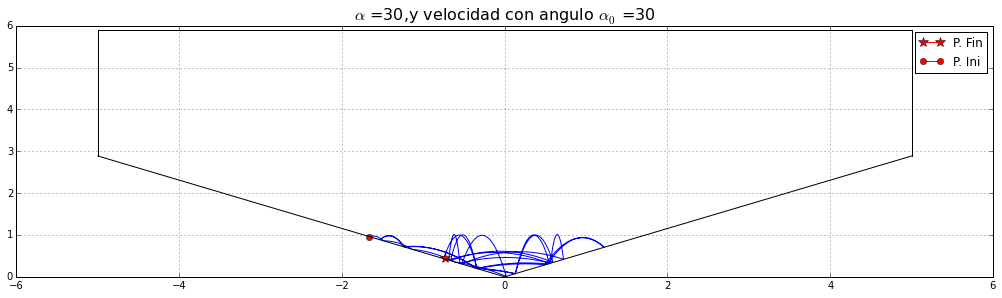

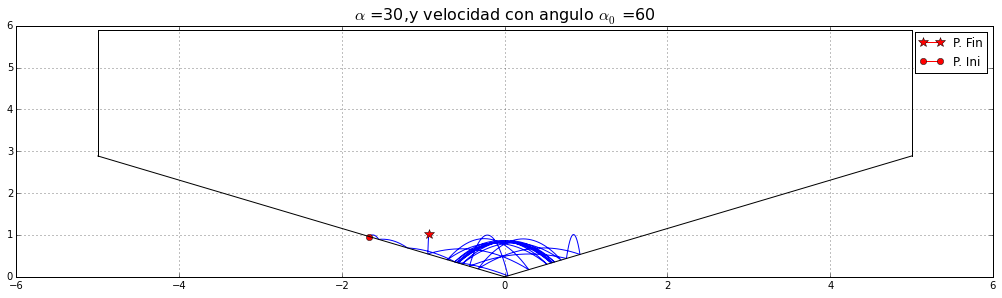

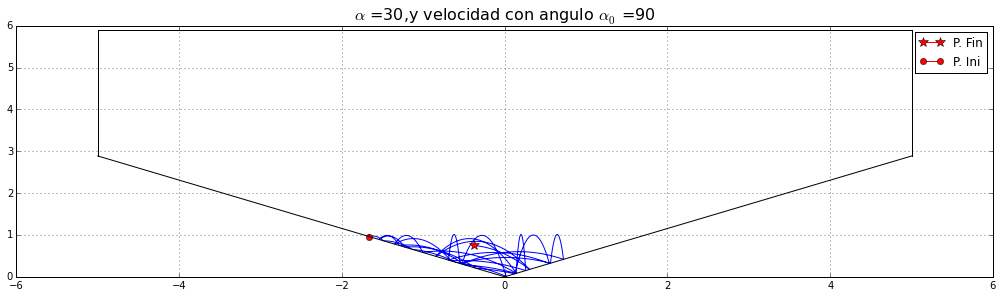

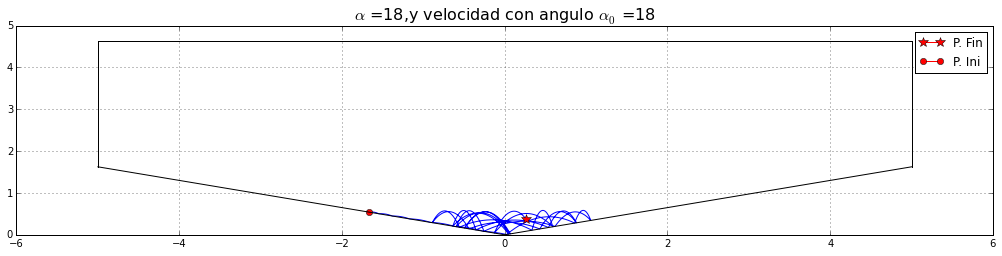

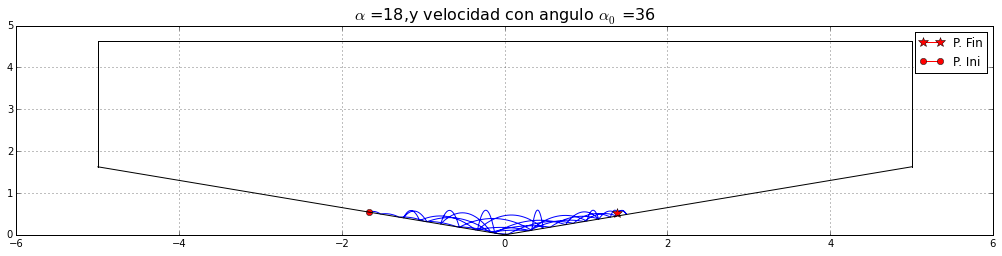

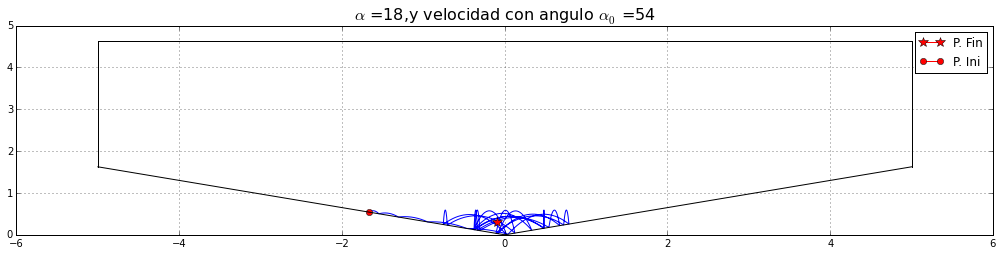

In [360]:
d,L=3.,10.
for alpha_rad in [np.pi/6.,np.pi/10.]:
    for i in [1,2,3]:
        x0=-L/6.
        y0=L/6.*np.tan(alpha_rad)
        vx0=1*np.cos(i*alpha_rad)
        vy0=1*np.sin(i*alpha_rad)
        alpha_deg=int(np.ceil(np.degrees(alpha_rad)))
        inicio=[x0,y0,vx0,vy0]
        rebotes,tray=trayectoria_con_rebote(inicio,alpha=np.degrees(alpha_rad),N=2500,mi_dt=0.005,error=1e-5)
        fig=plt.figure(figsize=(1.75*L,0.75*np.ceil(frontera_techo(alpha_rad,d,L))))
        ax = fig.add_subplot(111)
        plt.plot(tray[:,0],tray[:,1])
        plt.plot(tray[-1,0],tray[-1,1],marker='*',color="red",markersize=10,label="P. Fin")
        plt.plot(x0,y0,marker='o',color="red",label="P. Ini")
        ax.set_title('$\\alpha$ ={},y velocidad con angulo $\\alpha_0$ ={}'.format(alpha_deg,i*alpha_deg),fontsize = 16)
        plt.legend()
        plot_caja(np.degrees(alpha_rad),d,L)
        print "Para alpha",alpha_deg,"y vel. con angulo",i,"*alpha=",i*alpha_deg,"hay",rebotes,"rebotes."
plt.show()

**b)**Ahora utilizamos las mismas condiciones iniciales pero utilizamos el modelo de fricción *fricV1*, el cual es lineal en la velocidad del cuerpo. Tomaremos los mismos parámetros de $N$ y $mi\ dt$ que en el inciso a), por lo que no necesariamente habrá el mismo número de rebotes.

Para alpha 30 y vel. con angulo 1 *alpha= 30 hay 29 rebotes.
Para alpha 30 y vel. con angulo 2 *alpha= 60 hay 29 rebotes.
Para alpha 30 y vel. con angulo 3 *alpha= 90 hay 36 rebotes.
Para alpha 18 y vel. con angulo 1 *alpha= 18 hay 33 rebotes.
Para alpha 18 y vel. con angulo 2 *alpha= 36 hay 38 rebotes.
Para alpha 18 y vel. con angulo 3 *alpha= 54 hay 30 rebotes.


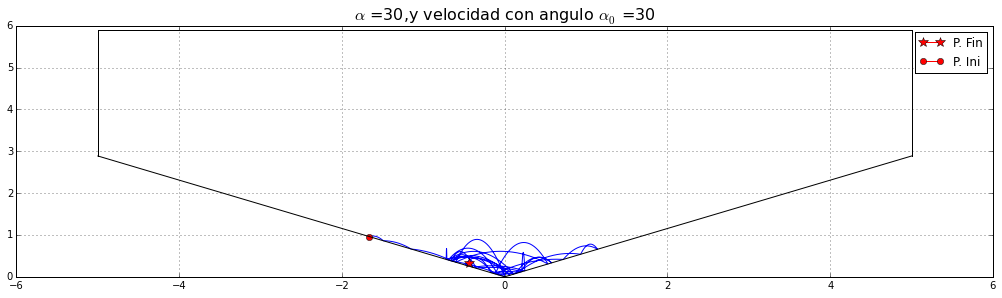

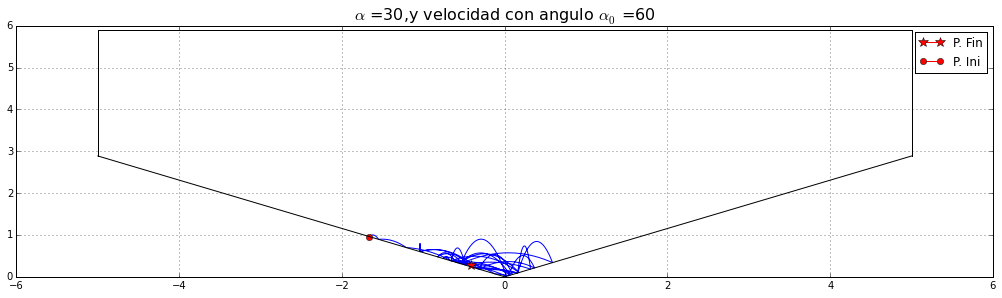

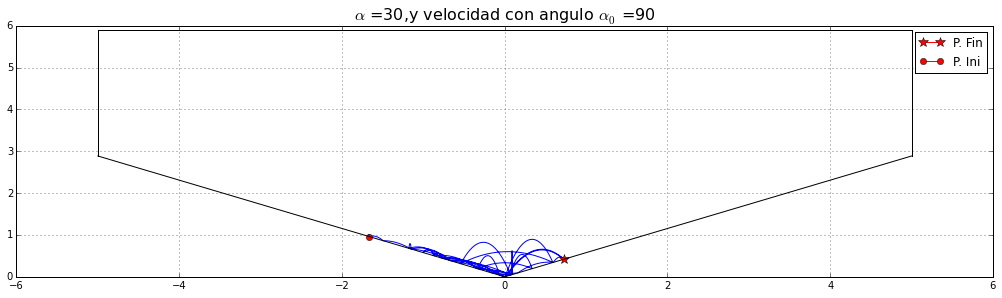

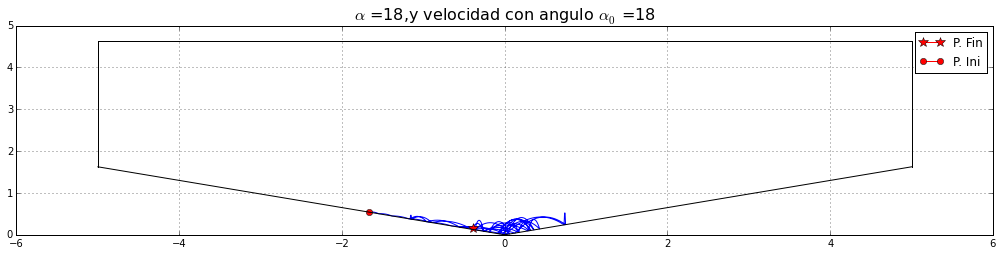

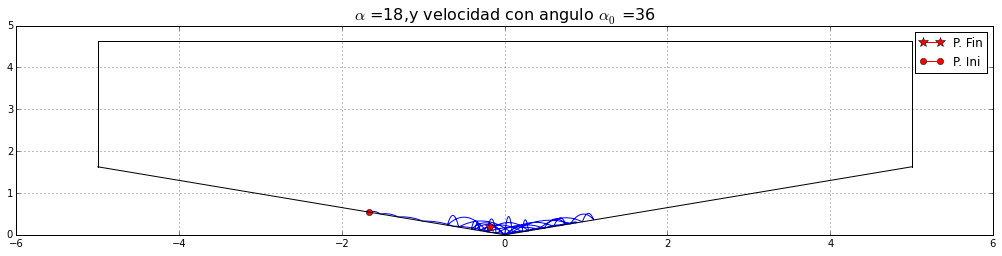

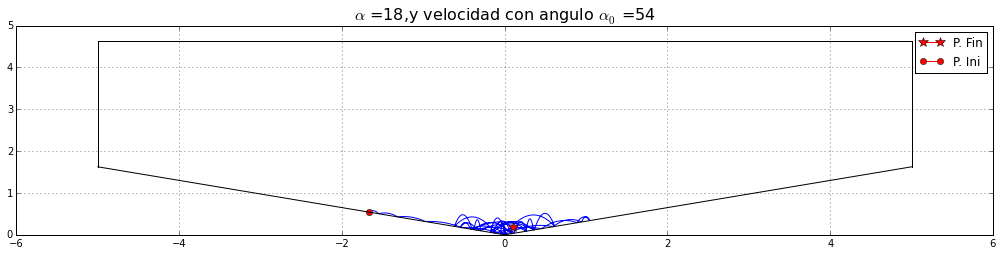

In [370]:
d,L=3.,10.
for alpha_rad in [np.pi/6.,np.pi/10.]:
    for i in [1,2,3]:
        x0=-L/6.
        y0=L/6.*np.tan(alpha_rad)
        vx0=1*np.cos(i*alpha_rad)
        vy0=1*np.sin(i*alpha_rad)
        alpha_deg=int(np.ceil(np.degrees(alpha_rad)))
        inicio=[x0,y0,vx0,vy0]
        rebotes,tray=trayectoria_con_rebote(inicio,alpha=np.degrees(alpha_rad),args=fricV1,N=2500,mi_dt=0.005,error=1e-5)
        fig=plt.figure(figsize=(1.75*L,0.75*np.ceil(frontera_techo(alpha_rad,d,L))))
        ax = fig.add_subplot(111)
        plt.plot(tray[:,0],tray[:,1])
        plt.plot(tray[-1,0],tray[-1,1],marker='*',color="red",markersize=10,label="P. Fin")
        plt.plot(x0,y0,marker='o',color="red",label="P. Ini")
        ax.set_title('$\\alpha$ ={},y velocidad con angulo $\\alpha_0$ ={}'.format(alpha_deg,i*alpha_deg),fontsize = 16)
        plt.legend()
        plot_caja(np.degrees(alpha_rad),d,L)
        print "Para alpha",alpha_deg,"y vel. con angulo",i,"*alpha=",i*alpha_deg,"hay",rebotes,"rebotes."
plt.show()

Se puede observar al comparar las gráficas de las trayectorias de los incisos a) y b) que hay una pérdida significativa de energía de la partícula al introducir la fricción. Aún así, el resultado sigue siendo análogo al del inciso a). Como era de esperarse, hay muchos más rebotes que en el inciso a). Esto es debido a la pérdida de energía.

**c)** Ahora repetiremos los procedimientos de los incisos a) y b) pero considerando mayores velocidades iniciales. Tomaremos los mismos parámetros de $N$ y $mi\ dt$ para los casos con y sin fricción.

**$i$)** Tomamos $|\vec{v}|=25\ $ en la condición inicial.

Sin fricción:

Para alpha 30 y vel. con angulo 1 *alpha= 30 hay 25 rebotes.
Para alpha 30 y vel. con angulo 2 *alpha= 60 hay 26 rebotes.
Para alpha 30 y vel. con angulo 3 *alpha= 90 hay 25 rebotes.
Para alpha 18 y vel. con angulo 1 *alpha= 18 hay 21 rebotes.
Para alpha 18 y vel. con angulo 2 *alpha= 36 hay 31 rebotes.
Para alpha 18 y vel. con angulo 3 *alpha= 54 hay 29 rebotes.


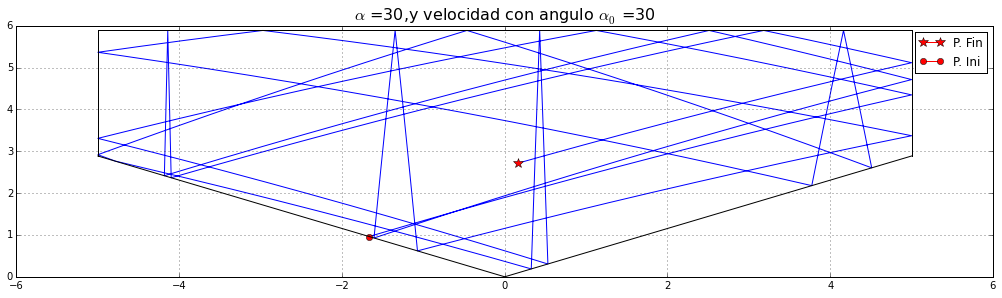

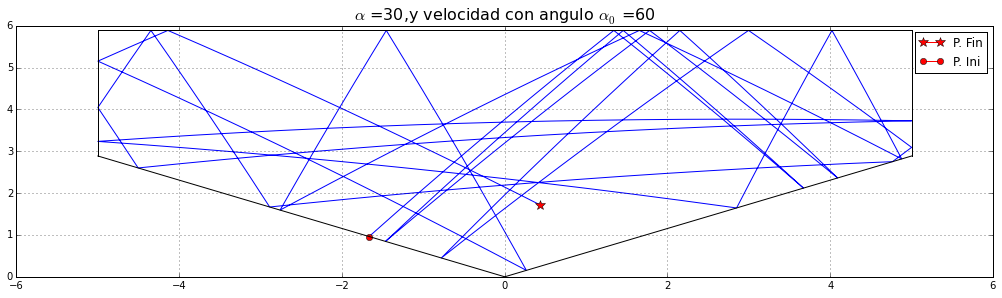

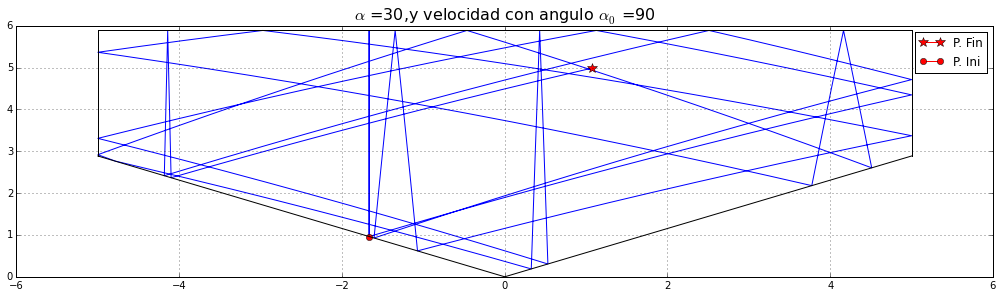

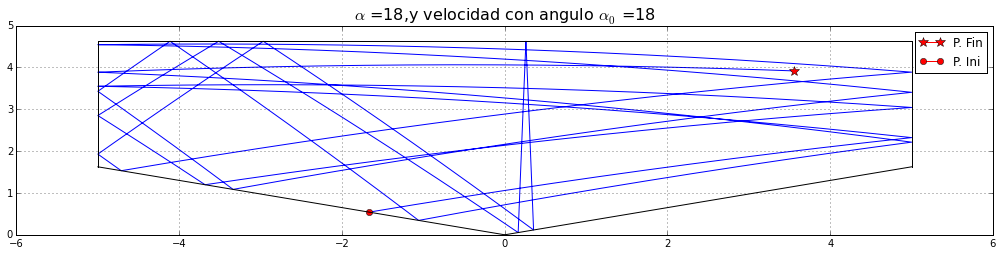

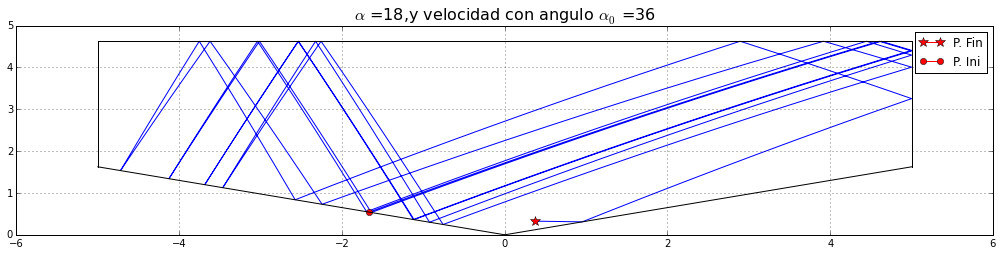

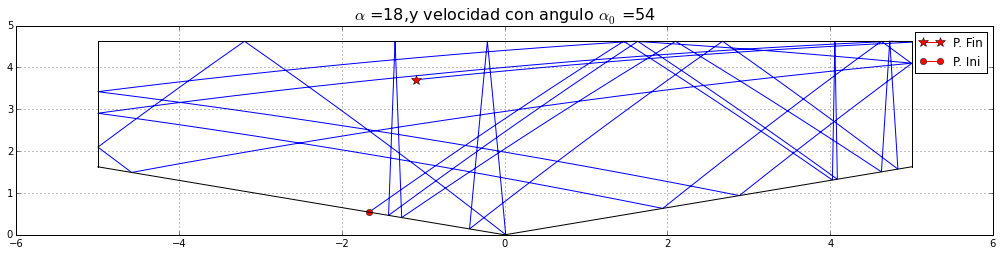

In [368]:
d,L=3.,10.
for alpha_rad in [np.pi/6.,np.pi/10.]:
    for i in [1,2,3]:
        x0=-L/6.
        y0=L/6.*np.tan(alpha_rad)
        vx0=25*np.cos(i*alpha_rad)
        vy0=25*np.sin(i*alpha_rad)
        alpha_deg=int(np.ceil(np.degrees(alpha_rad)))
        inicio=[x0,y0,vx0,vy0]
        rebotes,tray=trayectoria_con_rebote(inicio,alpha=np.degrees(alpha_rad),args=0,N=8000,mi_dt=0.0008,error=1e-5)
        fig=plt.figure(figsize=(1.75*L,0.75*np.ceil(frontera_techo(alpha_rad,d,L))))
        ax = fig.add_subplot(111)
        plt.plot(tray[:,0],tray[:,1])
        plt.plot(tray[-1,0],tray[-1,1],marker='*',color="red",markersize=10,label="P. Fin")
        plt.plot(x0,y0,marker='o',color="red",label="P. Ini")
        ax.set_title('$\\alpha$ ={},y velocidad con angulo $\\alpha_0$ ={}'.format(alpha_deg,i*alpha_deg),fontsize = 16)
        plt.legend()
        plot_caja(np.degrees(alpha_rad),d,L)
        print "Para alpha",alpha_deg,"y vel. con angulo",i,"*alpha=",i*alpha_deg,"hay",rebotes,"rebotes."
plt.show()

Con fricción:

Para alpha 30 y vel. con angulo 1 *alpha= 30 hay 18 rebotes.
Para alpha 30 y vel. con angulo 2 *alpha= 60 hay 21 rebotes.
Para alpha 30 y vel. con angulo 3 *alpha= 90 hay 20 rebotes.
Para alpha 18 y vel. con angulo 1 *alpha= 18 hay 18 rebotes.
Para alpha 18 y vel. con angulo 2 *alpha= 36 hay 23 rebotes.
Para alpha 18 y vel. con angulo 3 *alpha= 54 hay 24 rebotes.


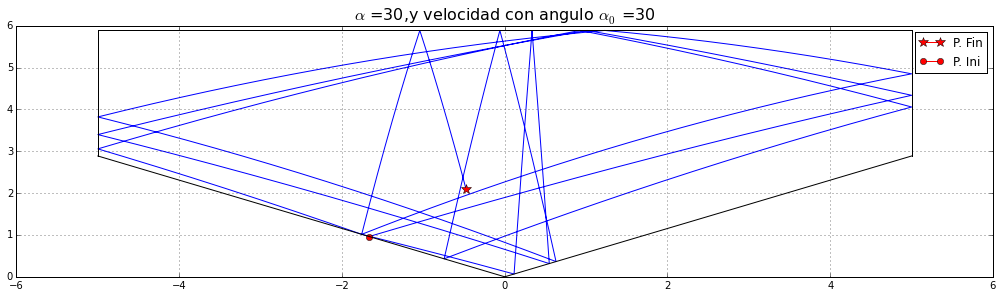

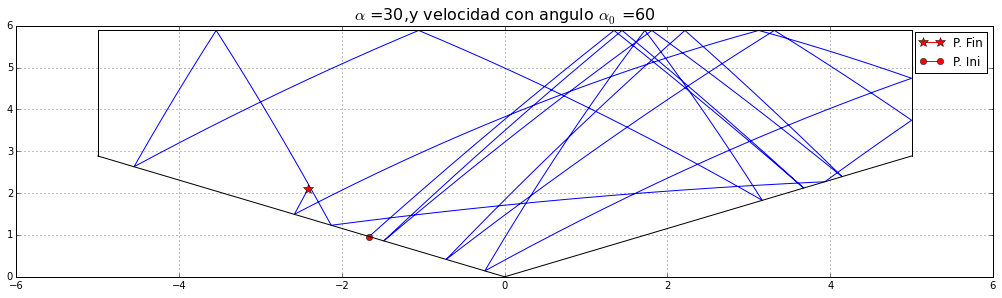

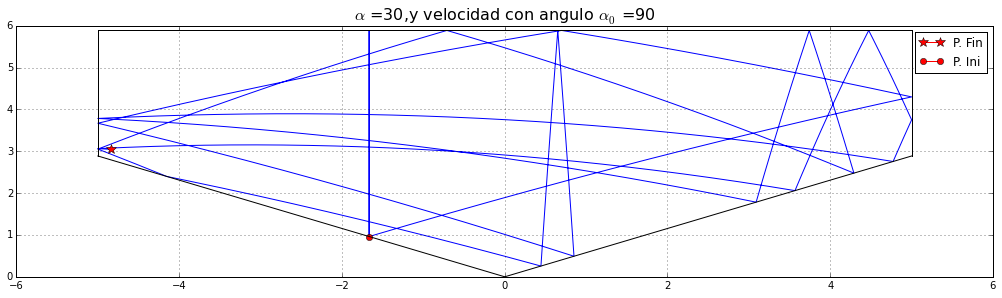

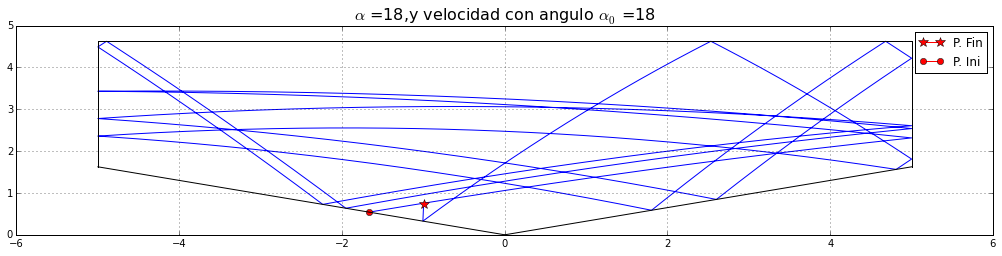

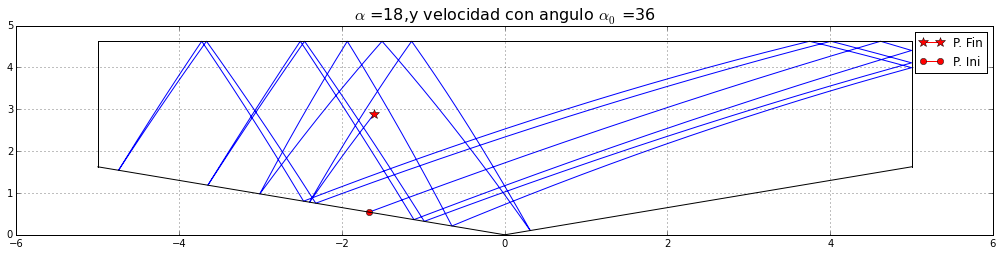

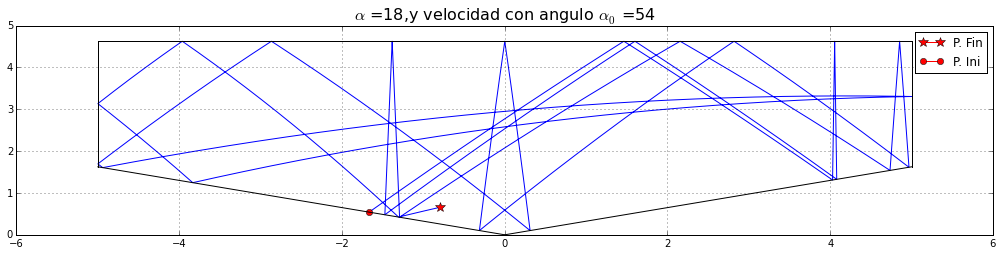

In [369]:
d,L=3.,10.
for alpha_rad in [np.pi/6.,np.pi/10.]:
    for i in [1,2,3]:
        x0=-L/6.
        y0=L/6.*np.tan(alpha_rad)
        vx0=25*np.cos(i*alpha_rad)
        vy0=25*np.sin(i*alpha_rad)
        alpha_deg=int(np.ceil(np.degrees(alpha_rad)))
        inicio=[x0,y0,vx0,vy0]
        rebotes,tray=trayectoria_con_rebote(inicio,alpha=np.degrees(alpha_rad),args=fricV1,N=8000,mi_dt=0.0008,error=1e-5)
        fig=plt.figure(figsize=(1.75*L,0.75*np.ceil(frontera_techo(alpha_rad,d,L))))
        ax = fig.add_subplot(111)
        plt.plot(tray[:,0],tray[:,1])
        plt.plot(tray[-1,0],tray[-1,1],marker='*',color="red",markersize=10,label="P. Fin")
        plt.plot(x0,y0,marker='o',color="red",label="P. Ini")
        ax.set_title('$\\alpha$ ={},y velocidad con angulo $\\alpha_0$ ={}'.format(alpha_deg,i*alpha_deg),fontsize = 16)
        plt.legend()
        plot_caja(np.degrees(alpha_rad),d,L)
        print "Para alpha",alpha_deg,"y vel. con angulo",i,"*alpha=",i*alpha_deg,"hay",rebotes,"rebotes."
plt.show()

**$ii$)**Tomamos $\ |\vec{v}|=60$ en la condición inicial.

Sin fricción:

Para alpha 30 y vel. con angulo 1 *alpha= 30 hay 66 rebotes.
Para alpha 30 y vel. con angulo 2 *alpha= 60 hay 74 rebotes.
Para alpha 30 y vel. con angulo 3 *alpha= 90 hay 66 rebotes.
Para alpha 18 y vel. con angulo 1 *alpha= 18 hay 80 rebotes.
Para alpha 18 y vel. con angulo 2 *alpha= 36 hay 80 rebotes.
Para alpha 18 y vel. con angulo 3 *alpha= 54 hay 73 rebotes.


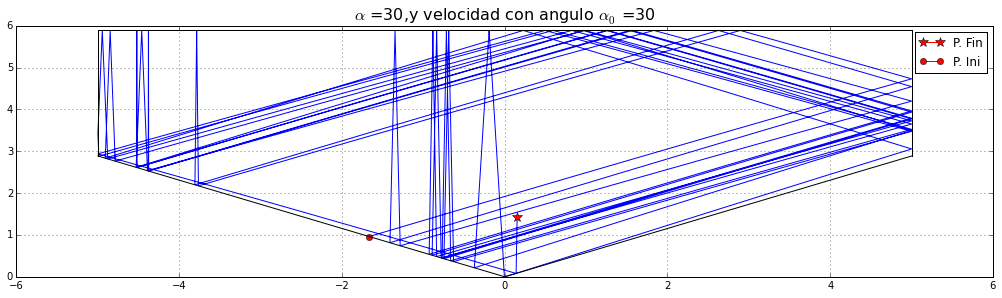

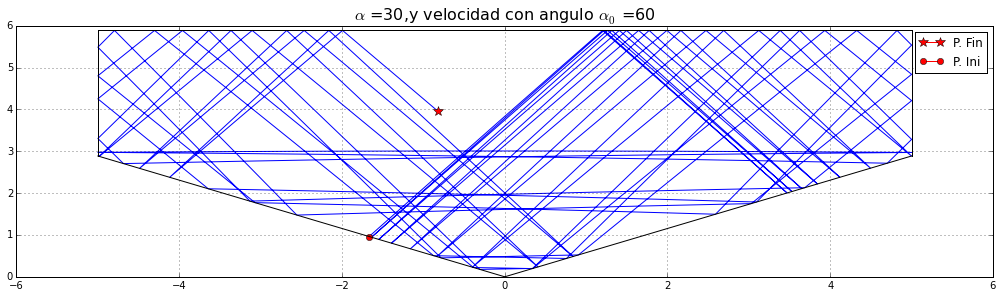

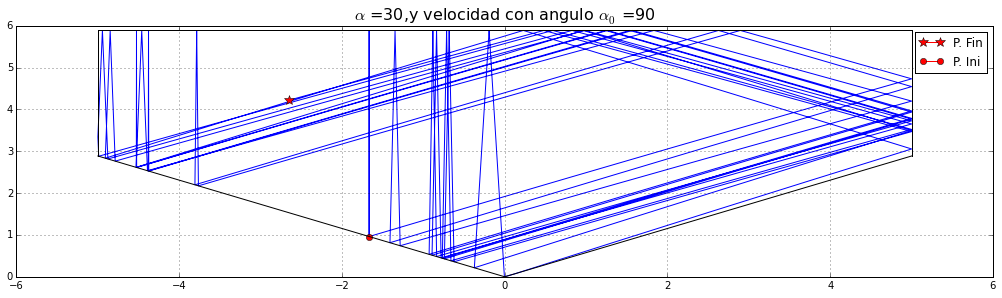

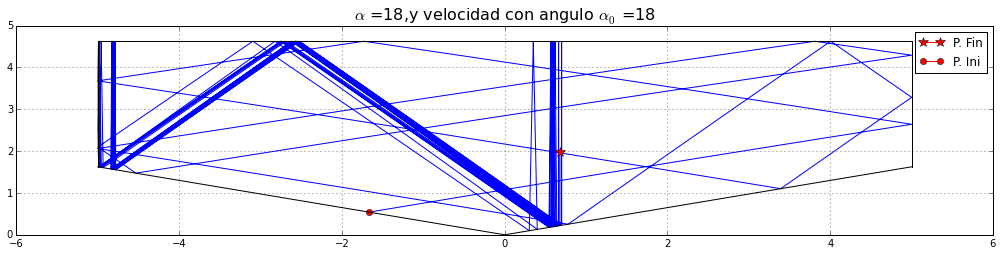

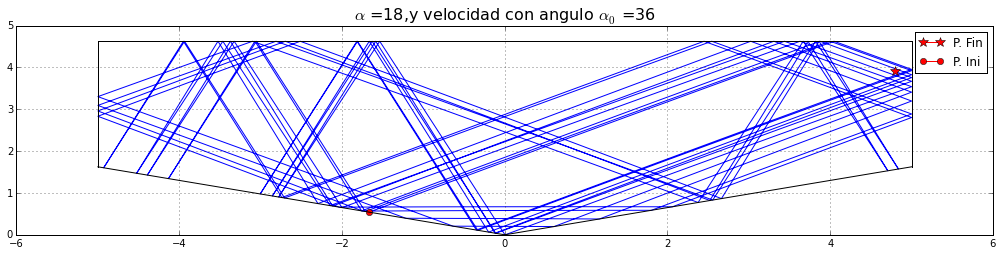

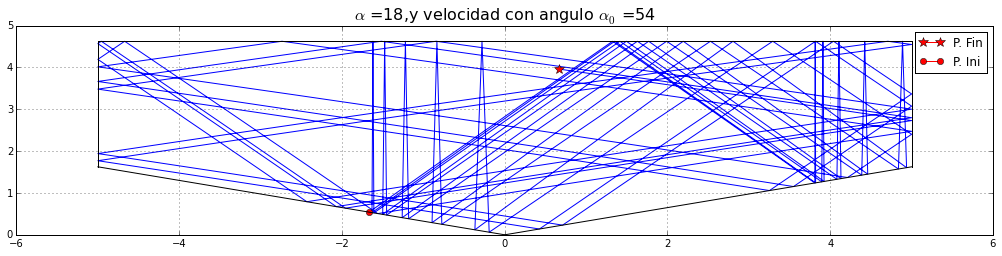

In [371]:
d,L=3.,10.
for alpha_rad in [np.pi/6.,np.pi/10.]:
    for i in [1,2,3]:
        x0=-L/6.
        y0=L/6.*np.tan(alpha_rad)
        vx0=60*np.cos(i*alpha_rad)
        vy0=60*np.sin(i*alpha_rad)
        alpha_deg=int(np.ceil(np.degrees(alpha_rad)))
        inicio=[x0,y0,vx0,vy0]
        rebotes,tray=trayectoria_con_rebote(inicio,alpha=np.degrees(alpha_rad),args=0,N=8000,mi_dt=0.0008,error=1e-5)
        fig=plt.figure(figsize=(1.75*L,0.75*np.ceil(frontera_techo(alpha_rad,d,L))))
        ax = fig.add_subplot(111)
        plt.plot(tray[:,0],tray[:,1])
        plt.plot(tray[-1,0],tray[-1,1],marker='*',color="red",markersize=10,label="P. Fin")
        plt.plot(x0,y0,marker='o',color="red",label="P. Ini")
        ax.set_title('$\\alpha$ ={},y velocidad con angulo $\\alpha_0$ ={}'.format(alpha_deg,i*alpha_deg),fontsize = 16)
        plt.legend()
        plot_caja(np.degrees(alpha_rad),d,L)
        print "Para alpha",alpha_deg,"y vel. con angulo",i,"*alpha=",i*alpha_deg,"hay",rebotes,"rebotes."
plt.show()

Con fricción:

Para alpha 30 y vel. con angulo 1 *alpha= 30 hay 48 rebotes.
Para alpha 30 y vel. con angulo 2 *alpha= 60 hay 54 rebotes.
Para alpha 30 y vel. con angulo 3 *alpha= 90 hay 48 rebotes.
Para alpha 18 y vel. con angulo 1 *alpha= 18 hay 52 rebotes.
Para alpha 18 y vel. con angulo 2 *alpha= 36 hay 61 rebotes.
Para alpha 18 y vel. con angulo 3 *alpha= 54 hay 57 rebotes.


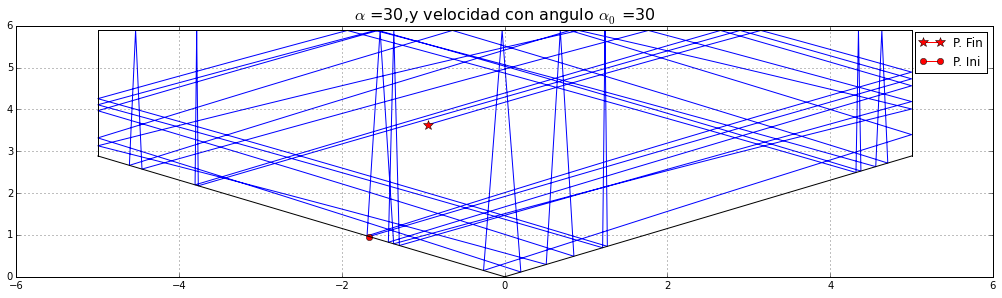

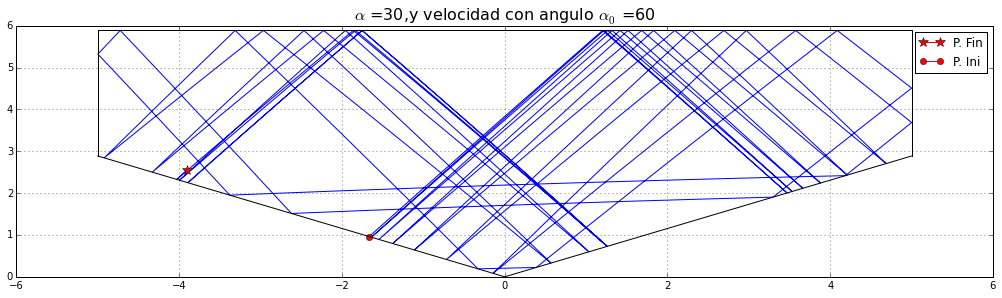

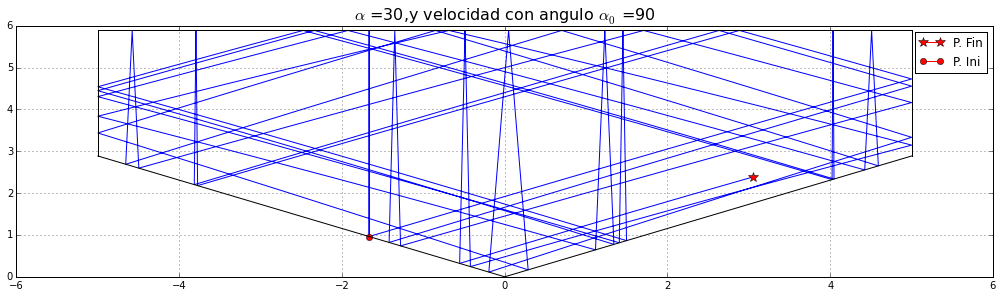

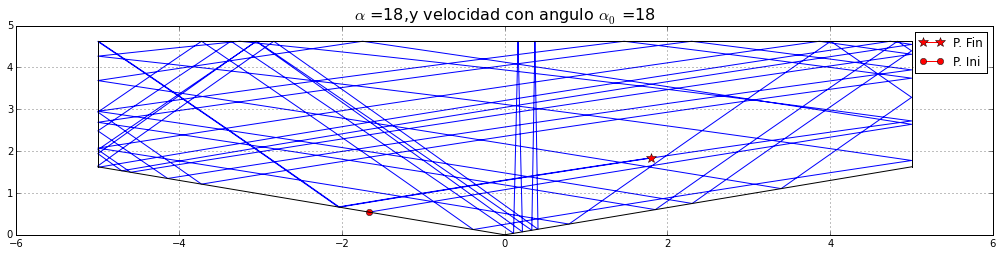

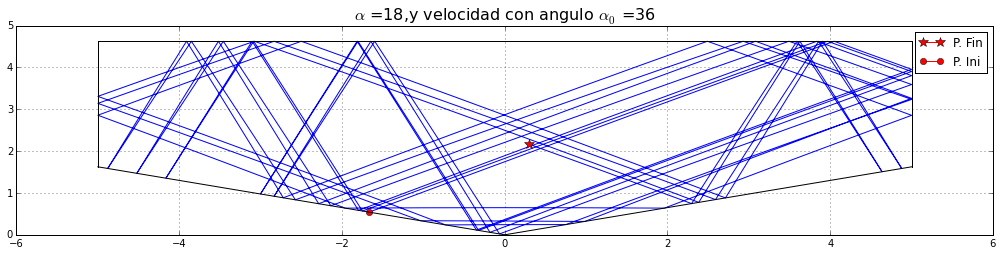

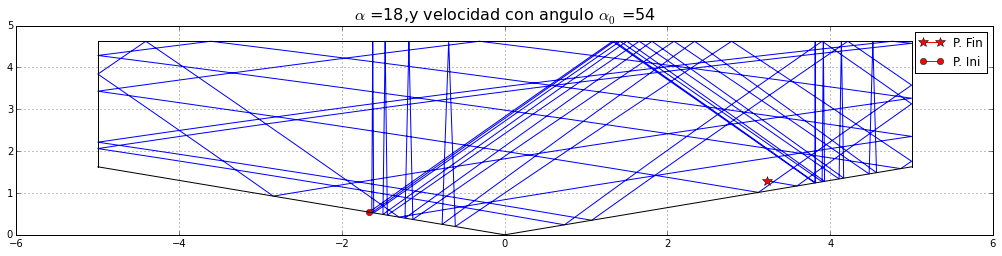

In [372]:
d,L=3.,10.
for alpha_rad in [np.pi/6.,np.pi/10.]:
    for i in [1,2,3]:
        x0=-L/6.
        y0=L/6.*np.tan(alpha_rad)
        vx0=60*np.cos(i*alpha_rad)
        vy0=60*np.sin(i*alpha_rad)
        alpha_deg=int(np.ceil(np.degrees(alpha_rad)))
        inicio=[x0,y0,vx0,vy0]
        rebotes,tray=trayectoria_con_rebote(inicio,alpha=np.degrees(alpha_rad),args=fricV1,N=8000,mi_dt=0.0008,error=1e-5)
        fig=plt.figure(figsize=(1.75*L,0.75*np.ceil(frontera_techo(alpha_rad,d,L))))
        ax = fig.add_subplot(111)
        plt.plot(tray[:,0],tray[:,1])
        plt.plot(tray[-1,0],tray[-1,1],marker='*',color="red",markersize=10,label="P. Fin")
        plt.plot(x0,y0,marker='o',color="red",label="P. Ini")
        ax.set_title('$\\alpha$ ={},y velocidad con angulo $\\alpha_0$ ={}'.format(alpha_deg,i*alpha_deg),fontsize = 16)
        plt.legend()
        plot_caja(np.degrees(alpha_rad),d,L)
        print "Para alpha",alpha_deg,"y vel. con angulo",i,"*alpha=",i*alpha_deg,"hay",rebotes,"rebotes."
plt.show()

El principal contraste con los incisos a) y b) es que las trayectorias dentro de la caja con prácticamente rectas entre los rebotes. Aún así se alcanza a apreciar un poco de curvatura en el caso de $|\vec{v}|=25\ $, además, de la influiencia de la fricción en este caso. Sin embargo, para el caso en el que $|\vec{v}|=60\ $ no se alcanza a ver que la trayectoria tenga la más mínima curvatura entre los rebotes, incluso en el caso de la fricción. Esto lo atribuimos a que las velocidades son muy grandes y que , en el intervalo de tiempo en el que se realizó la solución, estas no alcanzan a disminuir a valores suficientemente pequeños como para que la fuerza de gravedad empieze a tomar relevancia.

**d)**  Ahora, dibujaremos los espacios fase $(x,p_x)\ $ y $\ (y,p_y)$ de la partícula en el caso sin fricción. Asumiremos una velocidad inicial tal que $|\vec{v}|=10\ $.

**$i$)** Consideraremos el caso en el que la partícula es lanzada hacia la derecha, formando un ángulo $\alpha$ con la horizontal.

Para alpha 30 y vel. con angulo alpha= 30 hay 52 rebotes.
Para alpha 18 y vel. con angulo alpha= 18 hay 73 rebotes.


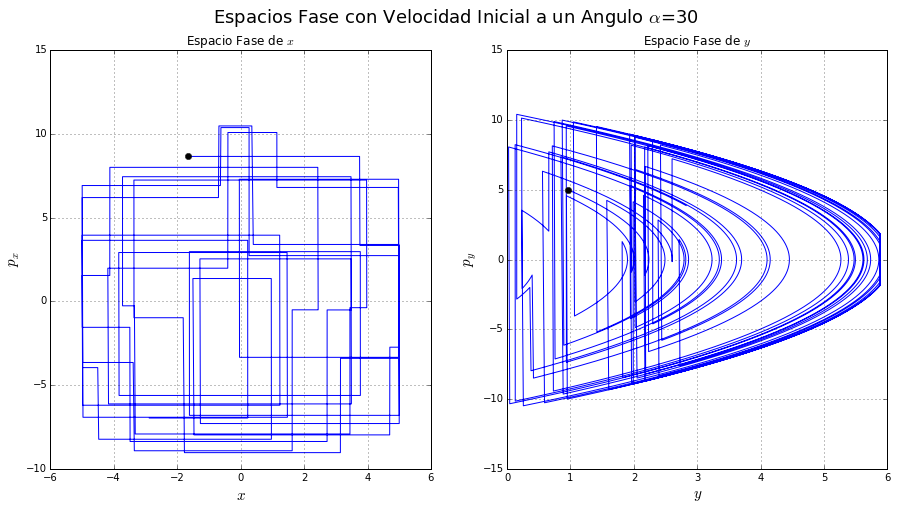

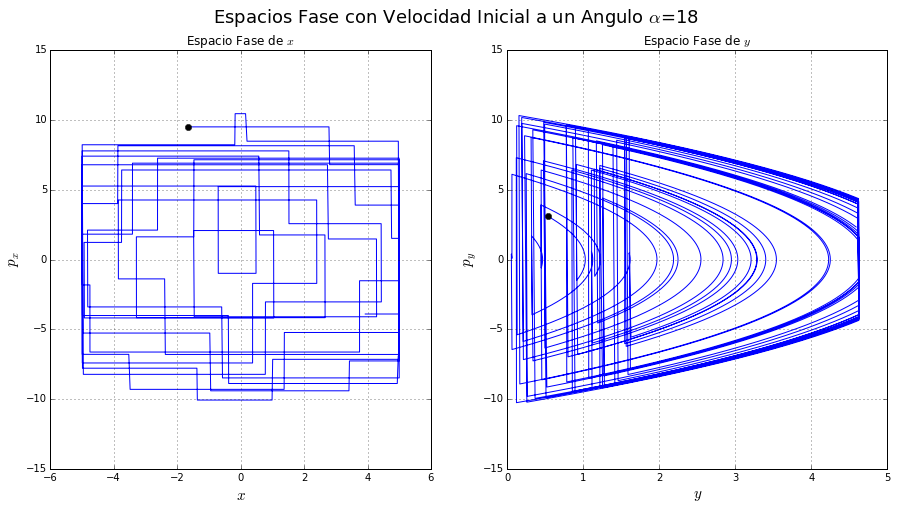

In [385]:
d,L,m=3.,10.,1.

for alpha_rad in [np.pi/6.,np.pi/10.]:
    x0=-L/6.
    y0=L/6.*np.tan(alpha_rad)
    vx0=10*np.cos(alpha_rad)
    vy0=10*np.sin(alpha_rad)
    alpha_deg=int(np.ceil(np.degrees(alpha_rad)))
    inicio=[x0,y0,vx0,vy0]
    rebotes,tray=trayectoria_con_rebote(inicio,alpha=np.degrees(alpha_rad),args=0,N=10000,mi_dt=0.005,error=1e-5)
    fig = plt.figure(figsize=(15,7.5))
    fig.suptitle("Espacios Fase con Velocidad Inicial a un Angulo $\\alpha$={}".format(alpha_deg),fontsize=18)
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title("Espacio Fase de $x$")
    ax1.plot(tray[:,0],m*tray[:,2],color="blue")
    ax1.plot(tray[0,0],m*tray[0,2],marker='o',color="black")
    plt.xlabel('$x$', fontsize=15)
    plt.ylabel('$p_x$', fontsize=15)
    plt.grid()
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Espacio Fase de $y$")
    ax2.plot(tray[:,1],m*tray[:,3],color="blue")
    ax2.plot(tray[0,1],m*tray[0,3],marker='o',color="black")
    plt.xlabel('$y$', fontsize=15)
    plt.ylabel('$p_y$', fontsize=15)
    plt.grid()
                  
    #ax.set_title('$\\alpha$ ={},y velocidad con angulo $\\alpha_0$ ={}'.format(alpha_deg,alpha_deg),fontsize = 16)
    #plt.legend()
    #plot_caja(np.degrees(alpha_rad),d,L)
    print "Para alpha",alpha_deg,"y vel. con angulo alpha=",alpha_deg,"hay",rebotes,"rebotes."
plt.show()

**$ii$)** Consideraremos el caso en el que la partícula es lanzada verticalmente hacia arriba.

Para alpha 30 y vel. con angulo alpha= 30 hay 48 rebotes.
Para alpha 18 y vel. con angulo alpha= 18 hay 64 rebotes.


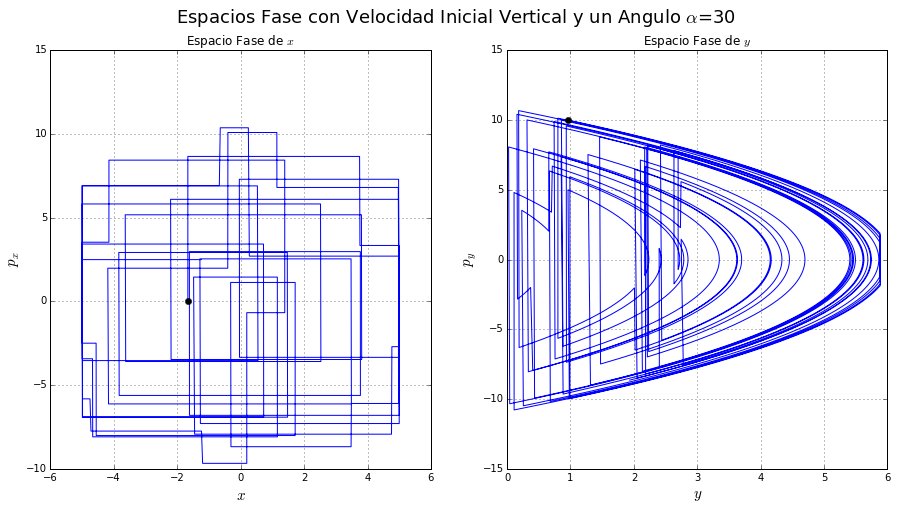

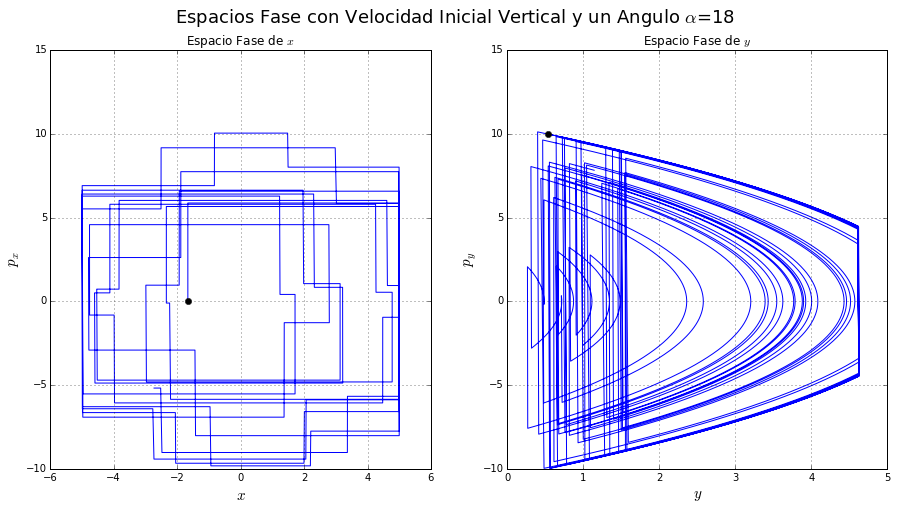

In [387]:
d,L,m=3.,10.,1.

for alpha_rad in [np.pi/6.,np.pi/10.]:
    x0=-L/6.
    y0=L/6.*np.tan(alpha_rad)
    vx0=10*np.cos(np.pi/2)
    vy0=10*np.sin(np.pi/2)
    alpha_deg=int(np.ceil(np.degrees(alpha_rad)))
    inicio=[x0,y0,vx0,vy0]
    rebotes,tray=trayectoria_con_rebote(inicio,alpha=np.degrees(alpha_rad),args=0,N=10000,mi_dt=0.005,error=1e-5)
    fig = plt.figure(figsize=(15,7.5))
    fig.suptitle("Espacios Fase con Velocidad Inicial Vertical y un Angulo $\\alpha$={}".format(alpha_deg),fontsize=18)
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title("Espacio Fase de $x$")
    ax1.plot(tray[:,0],m*tray[:,2],color="blue")
    ax1.plot(tray[0,0],m*tray[0,2],marker='o',color="black")
    plt.xlabel('$x$', fontsize=15)
    plt.ylabel('$p_x$', fontsize=15)
    plt.grid()
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Espacio Fase de $y$")
    ax2.plot(tray[:,1],m*tray[:,3],color="blue")
    ax2.plot(tray[0,1],m*tray[0,3],marker='o',color="black")
    plt.xlabel('$y$', fontsize=15)
    plt.ylabel('$p_y$', fontsize=15)
    plt.grid()
                  
    #ax.set_title('$\\alpha$ ={},y velocidad con angulo $\\alpha_0$ ={}'.format(alpha_deg,alpha_deg),fontsize = 16)
    #plt.legend()
    #plot_caja(np.degrees(alpha_rad),d,L)
    print "Para alpha",alpha_deg,"y vel. con angulo alpha=",alpha_deg,"hay",rebotes,"rebotes."
plt.show()

En el espacio fase de $x$ parece dominar el comportamiento de un partícula en una caja cuadrada (las paredes) y los planos. Esto se debe a que la gravedad no afecta el movimiento en esta dirección. Sin embargo,  los  saltos y cambios de dirección en el espacio fase no los podemos atribuir con choques con el techo de la caja, pues estos no cambian el movimiento en dirección $x$.
Por otro lado, en el espacio fase de $y$ el comportamiento de la partícula se asemeja más al de un cuerpo en caida libre, pero aquí se encuentra truncada debido a los rebotes con el techo. En general, es clara la reflexión con las paredes verticales y el techo porque estas cambian el signo de los momentos. Cuando esto no ocurre podemos concluir que la colisión debio se con alguno de los planos.

# Problema 4

Se tiene una partícula de masa $m=1$ en una caja circular como se muestra en la figura. Los radios de la figura $a$ y $b$ son tales que $b=2a$.
<img src="Figura_p4.png" style="width: 15%; height: 15%"/>
**a)** Realice una simulación donde la partícula realiza varios rebotes en las paredes de la caja. Suponga condiciones iniciales arbitrarias.

**b)**¿Existen condiciones iniciales que hagan que la partícula quede encasillada en sólo un sector de la caja? De ser así, muestre cuales son tales condiciones o demuestre porque no se puede obtener dicha situación.

**c)**Si ahora se tiene un campo gravitacional uniforme $\vec{g}=10\hat{n}$, ¿qué condiciones iniciales se tendrían que cumplir para que la partícula sólo pueda ocupar la mitad de la dona.

# Solución

En este caso será más cómodo realizar los cálculos en coordenadas polares debido a la simetría del sistema,sobretodo por los cálculos de rebotes. Consideraremos que el campo gravitacional uniforme que se introducirá en el inciso c) será vertical hacia abajo. Dado que los vectores unitarios en coordenadas polares planas son:

$$\begin{cases}\hat{r} &=& cos\theta\hat{i} &+& sin\theta\hat{j} \\ \hat{\theta} &=& -sin\theta\hat{i} &+& cos\theta\hat{j} \end{cases}\quad \Rightarrow \quad \begin{cases} \hat{i} &=& cos\theta \hat{r} &-& sin\theta \hat{\theta}  \\ \hat{j} &=&  sin\theta \hat{r} &+& cos\theta \hat{\theta} \end{cases}.$$ 
Con esto, vemos que la ecuación diferencial se puede escribir como $m\ddot{\vec{r}}=-g\hat{j}= -gsin\theta \hat{r} -g cos\theta \hat{\theta}$, donde descompusimos la fuerza gravitacional en dirección radial y tangencial. En el problema 1 de esta tarea ya habíamos deducido que $\vec{v}=\dot{\vec{r}}=\dot{r}\ \hat{r} + r\dot{\theta}\ \hat{\theta} \Rightarrow \vec{a}=\ddot{\vec{r}}=(\ddot{r}-r\dot{\theta}^2)\ \hat{r}+(2\dot{r}\dot{\theta}+r\ddot{\theta})\ \hat{\theta}$. Entonces, al hacer las cuentas vemos que el sistema de ecuaciones esta dado por:

$$\begin{cases} \text{para }\hat{r}:\quad  \ddot{r} = r\dot{\theta}^2-\frac{g}{m}sin\theta \\
\text{para }\hat{\theta}:\quad \ddot{\theta}=-2\frac{\dot{r}\dot{\theta}}{r} -\frac{g}{m}cos\theta \end{cases}$$

Para resolver la ecuación hacemos el cambio de variable $\begin{cases}r_1=r(t)\\r_2=\theta(t) \\r_3=\dot{r}(t)\\r_4=\dot{\theta}(t) \end{cases} \Rightarrow \begin{cases}\dot{r_1}=r_3\\ \dot{r_2}=r_4 \\ \dot{r_3}=\ddot{r}(t)\\ \dot{r_4}=\ddot{\theta}(t) \end{cases}$. 

Por tanto, el sistema se puede escribir como $\dot{\vec{r}}=\vec{g}(t,\vec{r})$, con $\vec{r}=(r_1,r_2,r_3,r_4)$ y 
$\vec{g}=(r_3,r_4,r_1 r_4^2-\frac{g}{m}sin\theta,-2\frac{r_3 r_4}{r_1}-\frac{g}{m}cos\theta)$.

A continuación programamos la ecuación de movimiento.

In [404]:
def mov_circulos(t,x_polares,args=0,m=1.): #x_polares=(r1,r2,r3,r4)=(r,theta,vr,vtheta)
    if args==0:
        g=0
    else:
        g=args
    r=x_polares #asumiremos que este es un array
    dr=[r[2],r[3],r[0]*r[3]**2-g*np.sin(r[1])/m,-2*r[2]*r[3]/r[0]-g*np.cos(r[1])/m]
    return np.array(dr) #regresa un array    

En coordenadas polares, el rebote es bastante simple, ya que la velocidad se refleja con respecto a la línea tangente al círculo en cuestión. Es decir, sólo se cambia el signo en la componente radial de la velocidad, mientras que la parte angular queda igual.

In [389]:
def reflexion_circulo(punto):
    """
    Toma el ultimo punto de la trayectoria,donde esta cruza uno de los circulos.
    Regresa el punto en la misma posicion espacial, pero refleja su velocidad respecto al circulo para obtener el rebote.
    """
    r = punto[0]
    theta = punto[1]
    vr = -punto[2]
    vtheta = punto[3]
    return np.array([r, theta, vr, vtheta])

Ahora programamos la función que calcula el punto en el que cruza las fronteras de la caja. Para esto ya asumimos que hay un cruce con alguna de la fronteras respectivas. En este caso podemos agrupar ambas fronteras en una sola función, en donde sólo debemos de especificar el radio que esta cruzando la partícula.

In [392]:
def rebote_circulo(punto_actual,mi_dt,radio=1.,args=0,N=100,error=1e-5):
    dt_busqueda = mi_dt/2
    y_izq = punto_actual #punto inicial del proceso de integracion actual
    t,sol = arg_rk4(mov_circulos,y_izq,[0,dt_busqueda],args)
    y_med = sol[-1,:] #toma el ultimo punto de la integracion como el valor de la solucion en el punto medio
    n=0
    while abs(y_izq[0]-radio)>error and n<=N:
        if(y_izq[0]-radio)*(y_med[0]-radio) <= 0:#hubo un cruce
            reinicio = y_izq
        else:
            reinicio = y_med
            
        dt_busqueda = dt_busqueda/2
        t,sol = arg_rk4(mov_circulos,reinicio,[0,dt_busqueda],args)    
        y_izq = reinicio
        y_med = sol[-1,:]
        n+=1
    return y_izq

A continuación, generamos la función integradora que resuelva la ecuación de movimiento, considerando las colisiones con las paredes de la caja. Esta regresa la trayectoria completa de la partícula.

In [395]:
def trayectoria_rebote_circulos(inicio,radio_int=1.,radio_ext=2.,args=0,N=100,mi_dt=0.1,error=1e-5):
    """
    Realiza integracion de la trayectoria mediante RK4. Si encuentra una frontera de la caja, calcula el rebote y 
    continua la integracion. Requiere que se le especifiquen los radios que delimitan la caja.
    A si mismo, puede tomar argumentos opcionales que se pasan al integrador de RK4.
    """
    #reacomodamos los radios si es necesario para garantizar que r_int<=r_ext
    if radio_ext<radio_int:
        radio0=radio_ext
        radio_ext=max(radio_int,radio_ext)
        radio_int=min(radio_int,radio0)
        
    trayectoria = np.zeros((N,len(inicio)))
    trayectoria[0,:] = np.array(inicio)
    contador_rebotes=0
    for i in xrange(N-1):
        t,sol_dt = arg_rk4(mov_circulos,trayectoria[i,:],[0,mi_dt],args,h=0.1*mi_dt)
        #ahora buscamos si hubo algun cruce

        if sol_dt[-1,0] <= radio_int: #si hay cruce con el radio interior
            contador_rebotes+=1
            punto_de_cruce=rebote_circulo(trayectoria[i,:],mi_dt,radio_int,args,N,error)   
            trayectoria[i+1,:] = reflexion_circulo(punto_de_cruce)
            #tomamos el punto de cruce como el siguiente punto de la solucion, pero con la velocidad reflejada
        elif sol_dt[-1,0] >= radio_ext: #si hay cruce con el radio exterior
            contador_rebotes+=1
            punto_de_cruce=rebote_circulo(trayectoria[i,:],mi_dt,radio_ext,args,N,error)   
            trayectoria[i+1,:] = reflexion_circulo(punto_de_cruce)
            #tomamos el punto de cruce como el siguiente punto de la solucion, pero con la velocidad reflejada
        else:
            trayectoria[i+1,:] = sol_dt[-1,:] #tomamos solo el punto final de la integración en la trayectoria
    return contador_rebotes,trayectoria    

Ahora definimos una función que grafique la caja, al igual que en el problema pasado. Sin embargo, ahora haremos las gráficas en modo polar.

In [452]:
def plot_circulos(r_int=1.,r_ext=2.):
    theta = np.linspace(0,2*np.pi, 100)
    r1 = r_int*np.ones(len(theta))
    plt.polar(theta, r1,color="red") #circulo interior
    plt.polar(theta, r1*r_ext/r_int,color="red") #circulo exterior
    plt.axis([0,2*np.pi, 0, r_ext + 1]) #[theta_ini,theta_fin,r_ini,r_fin]
    return

**a)** Supondremos una condición inicial arbitraria dentro de la caja de modo que la partícula esté rebotando dentro de esta. Más especificamente, la condición inicial será aleatoria dentro de ciertos valores permitidos.

In [465]:
from random import *

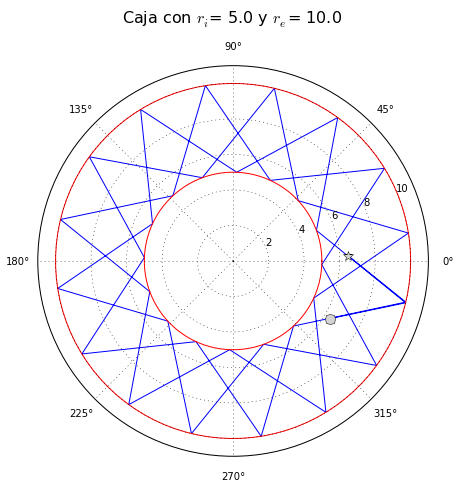

In [475]:
r_int=5.
r_ext=10.
r,theta=uniform(r_int,r_ext),uniform(r_int,r_ext)
vr,vtheta=uniform(-2.5,2.5),uniform(-0.5,0.5)
inicio = [r,theta,vr,vtheta]
rebotes,tray=trayectoria_rebote_circulos(inicio,radio_int=r_int,radio_ext=r_ext,args=0,N=1000,mi_dt=0.1,error=1e-5)

fig=plt.figure(figsize=(7,7))
plt.polar(tray[:,1], tray[:,0])
plt.polar(inicio[1], inicio[0], color = 'lightgrey', marker = 'o',markersize=10)
plt.polar(tray[-1,1], tray[-1,0], color = 'lightgrey', marker = '*',markersize=10)
plt.title('Caja con $r_i$= {} y $r_e$= {} \n'.format(r_int,r_ext), fontsize = 16)
plot_circulos(r_int,r_ext)
plt.show()

**b)** En este caso (sin gravedad) las condiciones iniciales no deperán de la posición inicial, sólo de la velocidad que la partíula tenga al inicio. Del inciso anterior y de las condiciones de rebote, podemos ver que la partícula mantiene una velocidad en dirección angular ($\dot{\theta}$) contante, por lo que podemos distinguir dos casos en los que la partícula se queda sólo en un sector de la caja:

**Caso 1:**Cuando la velocidad angular inicial es cero.

**Caso 2:**Cuando la velocidad angular inicial es mayor que la norma de la velocidad radial de modo que no pueda tener ciertos valores del radio.

Graficamos las simulaciones:

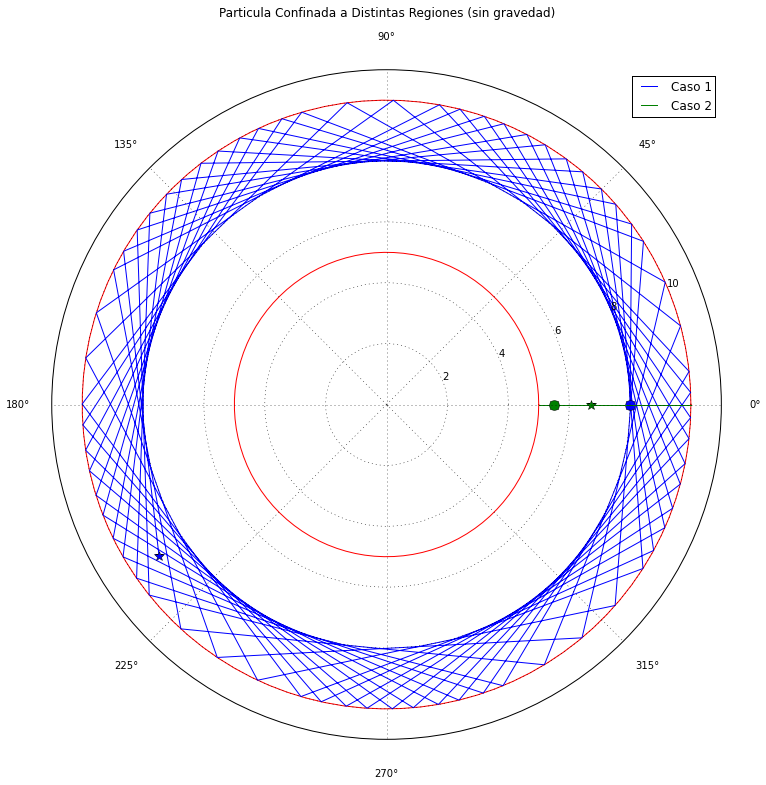

rebotes caso 1: 66
rebotes caso 2: 4


In [497]:
r_int=5.
r_ext=10.

fig = plt.figure(figsize=(12,12))
plot_circulos(r_int,r_ext)
plt.title("Particula Confinada a Distintas Regiones (sin gravedad)\n")

inicio1 = [8.,0.,0.5,7.]
rebotes1,tray1=trayectoria_rebote_circulos(inicio1,radio_int=r_int,radio_ext=r_ext,args=0,N=200,mi_dt=0.1,error=1e-5)
plt.polar(tray1[:,1], tray1[:,0],label="Caso 1")
plt.polar(inicio1[1], inicio1[0], color = 'blue', marker = 'o',markersize=10)
plt.polar(tray1[-1,1], tray1[-1,0], color = 'blue', marker = '*',markersize=10)

inicio2 = [5.5,0,1.2,0]
rebotes2,tray2=trayectoria_rebote_circulos(inicio2,radio_int=r_int,radio_ext=r_ext,args=0,N=200,mi_dt=0.1,error=1e-5)
plt.polar(tray2[:,1], tray2[:,0],label="Caso 2")
plt.polar(inicio2[1], inicio2[0], color = 'green', marker = 'o',markersize=10)
plt.polar(tray2[-1,1], tray2[-1,0], color = 'green', marker = '*',markersize=10)

plt.legend()
plt.show()

print "rebotes caso 1:", rebotes1
print "rebotes caso 2:", rebotes2

Como se observa, hay una gran simetría en el caso 1, puesto que se mantiene la componente angular de la velocidad. Además, vemos que la trayectoria en este caso no puede pasar de cierto radio. Del mismo modo, la trayectoria del caso dos permanece con un valor angular constante. Para ser más precisos, vemos que:

In [499]:
print min(tray1[:,0]) #radio esta acotado inferiormente por 8
print min(tray2[:,1]),max(tray2[:,1]) #angulo es constante (cero)

8.0
0.0 0.0


**c)** Ahora consideraremos el campo gravitacional  uniforme dado por: $\vec{g}=10\hat{n}=-10\hat{j}$. Al igual que en el inciso anterior consideraremos dos casos:

**Caso 1:** Dado que no hay fricción, si queremos que la partícula se quede en una mitad de la dona, debe tener energía máxima en el punto más alto de su trayectoria. Una forma sencilla de lograr esto es soltarla desde la mitad de la dona.

**Caso 2:** La partícula se queda en la parte superior de la dona si no tiene velocidad angular inicial y se encuentra justamente en la parte superior de la dona. Por tanto, en este caso la partícula sólo puede estar en la mitad superior de la caja, aunque sólo en una parte muy pequeña de esta.

A continuación mostramos las simulaciones:

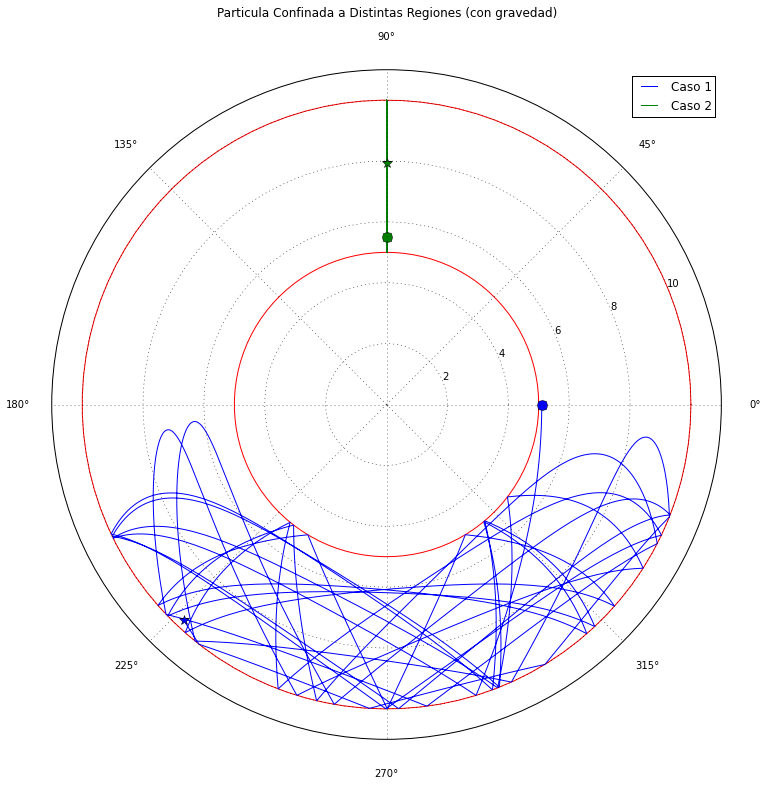

rebotes caso 1: 39
rebotes caso 2: 24


In [503]:
r_int=5.
r_ext=10.

fig = plt.figure(figsize=(12,12))
plot_circulos(r_int,r_ext)
plt.title("Particula Confinada a Distintas Regiones (con gravedad)\n")

inicio1 = [5.1,0.,0.,0.]
rebotes1,tray1=trayectoria_rebote_circulos(inicio1,radio_int=r_int,radio_ext=r_ext,args=10.,N=2000,mi_dt=0.01,error=1e-5)
plt.polar(tray1[:,1], tray1[:,0],label="Caso 1")
plt.polar(inicio1[1], inicio1[0], color = 'blue', marker = 'o',markersize=10)
plt.polar(tray1[-1,1], tray1[-1,0], color = 'blue', marker = '*',markersize=10)

inicio2 = [5.5,np.pi/2.,10.,0]
rebotes2,tray2=trayectoria_rebote_circulos(inicio2,radio_int=r_int,radio_ext=r_ext,args=10.,N=2000,mi_dt=0.01,error=1e-5)
plt.polar(tray2[:,1], tray2[:,0],label="Caso 2")
plt.polar(inicio2[1], inicio2[0], color = 'green', marker = 'o',markersize=10)
plt.polar(tray2[-1,1], tray2[-1,0], color = 'green', marker = '*',markersize=10)

plt.legend()
plt.show()

print "rebotes caso 1:", rebotes1
print "rebotes caso 2:", rebotes2

Observamos que en ambos casos, las partículas estan confinadas a una región de la caja y se mantienen ahí.

# Punto Extra

Realice una animación para alguna trayectoria del problema en el inciso (3c) y otra animación para el inciso (4c).